In [1]:
import numpy as np
import operator
import logging
import time

from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass, matched_filter, sigma
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_fd_waveform

import optuna

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

/mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Set-up the logging 
logger = logging.getLogger(__name__)  
logger.setLevel(logging.INFO) # set log level 

file_handler = logging.FileHandler('GWtunaBBHNotebook.log') # define file handler and set formatter
formatter    = logging.Formatter('%(asctime)s : %(levelname)s : %(name)s : %(message)s')
file_handler.setFormatter(formatter)

logger.addHandler(file_handler) # add file handler to logger

In [3]:
class NeedsInvestigatingCallback(object):
    """A callback for Optuna which identifies potential events."""

    def __init__(self, early_stopping_rounds: int, snr_threshold: int, direction: str = "minimize") -> None:
        self.snr_threshold = snr_threshold
        self.early_stopping_rounds = early_stopping_rounds
        
        self._iter = 0

        if direction == "minimize":
            self._operator = operator.lt
            self._score = np.inf
        elif direction == "maximize":
            self._operator = operator.gt
            self._score = -np.inf
        else:
            ValueError(f"invalid direction: {direction}")

    def __call__(self, study: optuna.Study, trial: optuna.Trial) -> None:
        """Goes onto Stocastic Gradient Descent."""
        if self._operator(study.best_value, self._score):
            self._iter = 0
            self._score = study.best_value
        else:
            self._iter += 1

        if self._score >= self.snr_threshold:
            if self._iter >= self.early_stopping_rounds:
                study.stop()
                print(study.best_params)

In [4]:
def confirmed_gw_timeseries(event, detector):
    merger = Merger(event)

    # Get the data from the Hanford detector
    strain = merger.strain(detector)

    # Remove the low frequency content and downsample the data to 2048Hz
    strain = resample_to_delta_t(highpass(strain, 15.0), 1.0/2048)

    # Remove 2 seconds of data from both the beginning and end
    conditioned = strain.crop(2, 2)
    
    return conditioned

def confirmed_gw_psd(conditioned):
    psd = conditioned.psd(4)

    psd = interpolate(psd, conditioned.delta_f)

    psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                      low_frequency_cutoff=15)
    return psd


In [5]:
def objective(trial):
    m1 = trial.suggest_float('m1', 2, 100, step=0.000001)
    m2 = trial.suggest_float('m2', 2, 100, step=0.000001)
    #s1 = trial.suggest_float('s1', -0.99, 0.99, step=0.000001)
    #s2 = trial.suggest_float('s2', -0.99, 0.99, step=0.000001)
    #hp, hc = get_td_waveform(approximant="IMRPhenomXAS", mass1=m1, mass2=m2, spin1z=s1, spin2z=s2, delta_t=conditioned.delta_t,f_lower=20)
    conditioned = confirmed_gw_timeseries(event, detector='H1')
    psd = confirmed_gw_psd(conditioned)
    f_conditioned = conditioned.to_frequencyseries()
    template, hc = get_fd_waveform(approximant="IMRPhenomD", mass1=m1, mass2=m2, delta_f=conditioned.delta_f, f_lower=20)
    print(f'template{template}')
    template.resize(len(psd))
    snr = matched_filter(template, f_conditioned, psd=psd, low_frequency_cutoff=20)
    print(f'The snr is {snr}')
    snr = snr.crop(2 + 4, 2)
    peak = abs(snr).numpy().argmax()
    snrp = abs(snr[peak])
    return float(snrp)

In [6]:
#Events = ["GW150914", "GW151012", "GW151226", "GW170104", "GW170608", "GW170729", "GW170809", "GW170814", "GW170817", "GW170818", "GW170823"]

Events = ["GW150914"]

template[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
The snr is [20.15318048-12.46365621j 22.5459669  -5.00908545j
 21.89084833 +2.79905091j ...  1.28706883-22.46192816j
  8.47536509-21.82459754j 15.1585314 -18.36275872j]
template[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
The snr is [-1.20827349-3.98997308j  4.45769092-4.19035953j  9.31991824-0.27629809j
 ... -1.92058407+8.38504744j -5.08570494+4.70576415j
 -4.93020148-0.28921181j]
template[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
The snr is [10.9129411  -9.01010028j 13.12124798 -2.73912002j
 12.21156247 +3.91186566j ... -5.95714817-14.11178591j
  0.04435052-15.26914498j  6.15802397-13.49835314j]
template[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
The snr is [ 4.71077851+7.79299682j -1.24678792+7.42691696j -5.50514399+2.94853213j
 ...  7.34618131-5.50892201j 10.04884118-1.24385361j
  9.18631722+4.16268117j]
template[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
The snr is [-19.00811043 +9.13621879j -19.47539248 +2.02

/tmp/ipykernel_9495/3980520897.py:11: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, target_name="SNR")
Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


template[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
The snr is [  3.57137386-7.78125505j   7.00191485-2.67690376j
   6.80061872+3.77753274j ... -10.87847996-4.02550673j
  -7.45641892-8.26554409j  -1.97791065-9.80946756j]
{'m1': 36.950122, 'm2': 36.881585}


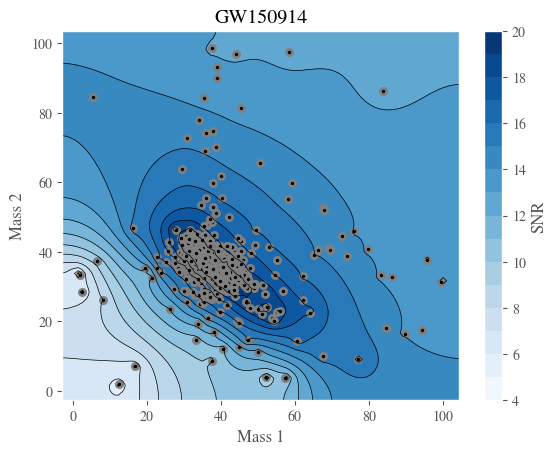

In [7]:
for event in Events: 
    start_time = time.time()
    optuna.logging.disable_default_handler()
    direction="maximize"
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction=direction)
    needs_to_be_investigated = NeedsInvestigatingCallback(300, snr_threshold=6, direction=direction)
    study.optimize(objective, callbacks=[needs_to_be_investigated], n_trials=1000)
    logger.info(("Time taken", time.time() - start_time))
    logger.info(f'The event is {event} and has the best {study.best_params} with a snr {study.best_value}')
    
    fig = optuna.visualization.matplotlib.plot_contour(study, target_name="SNR")
    fig.set_title(f"{event}")
    fig.set_xlabel('Mass 1')
    fig.set_ylabel('Mass 2')

/tmp/ipykernel_9495/1964054597.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study, target_name="SNR")


Text(0.5, 1.0, '')

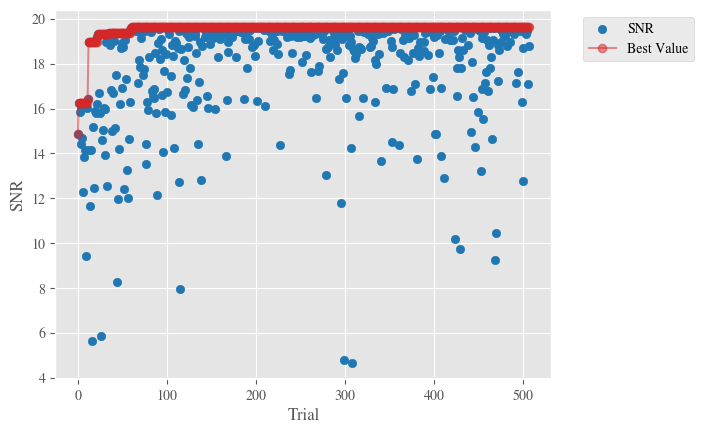

In [8]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study, target_name="SNR")
fig.set_title("")

/tmp/ipykernel_9495/4230620112.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_edf(study)


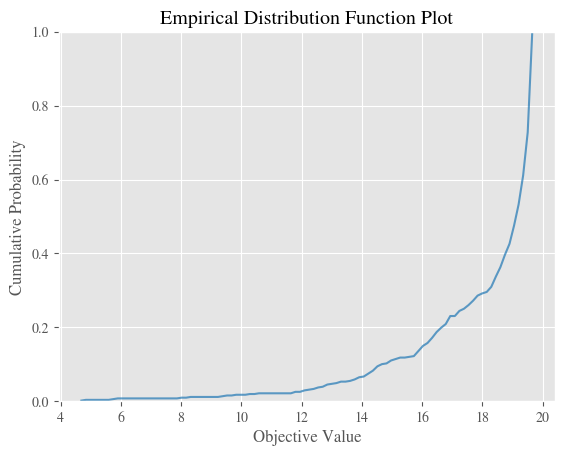

In [9]:
fig = optuna.visualization.matplotlib.plot_edf(study)